# Gitcoin Grants Analyses

As requested in a [gitcoin grant itself](https://gitcoin.co/issue/gitcoinco/skunkworks/252/100027341), I want to take a look at the data of Gitcoin grants since the program's creation in November 2017. I hope to elicit some novel information from the data on how quadratic funding has looked so far, and how we might compare it to other systems of funding these sorts of projects.

## Background

[Gitcoin](https://gitcoin.co/) is a program to crowd-fund open source projects by using cryptocurrencies and [quadratic funding](https://vitalik.ca/general/2019/12/07/quadratic.html). The idea is a twist on [quadratic voting](https://en.wikipedia.org/wiki/Quadratic_voting) which enables democratic participants to not only indicate their preference, but also their **level** of preference. 

## Data Exploration and Cleaning

Let's take a look at the basic data sets we've got from the grant that spurred this analysis, utilizing the handy [pandas_profiling](https://pandas-profiling.github.io/pandas-profiling/docs/master/index.html) tool. 

In [39]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("plotting.backend", "matplotlib")
sns.set_theme(style="darkgrid")
plt.figure(figsize=(20, 5))

# Convert currency amounts to a Decimal to safely deal with currency arithmetic
def currency_to_decimal(value):
  value = str(value)
  value = value.replace(",", "")
  value = value.replace("$", "")
  if value == "":
    value = "0.00"
  return float(value)

grants_data = pd.read_csv("./data/gr1-gr12.csv", converters={"match_amount": currency_to_decimal, "crowdfund_amount_contributions_usd": currency_to_decimal, "total": currency_to_decimal})

# Finding a lot of missing values in the `crowdfund_amount_contributions_usd` and `total` which seem to be cases where
# either there was no funding period, or the only funder was the Gitcoin bot. https://gitcoin.co/gitcoinbot
# Add column to indicate where gitcoin bot is only funder
grants_data["only_gitcoin_bot_funded"] = np.where((grants_data["match_amount"] > 0) & (grants_data["num_unique_contributors"] == 0), True, False)

# Clean up some inconsistencies with `region`
grants_data.loc[(grants_data["region"] == "undefined") | (grants_data["region"].isna()), "region"] = "none"

# Let Pandas know what data types we're dealing with
grants_data["round_start_date"] = pd.to_datetime(grants_data['round_start_date'],format='%Y-%m-%d')
grants_data["round_end_date"] = pd.to_datetime(grants_data['round_end_date'],format='%Y-%m-%d')
grants_data = grants_data.astype({
  "round_number": "category",
  "grant_title": str,
  "region": "category",
  "category": "category",
  "url": str})

# Get a nice overview of our data
pandas_profiling.ProfileReport(grants_data)

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


## Data Analysis

Let's take a look at couple things that you'd probably expect to be true generally about the data. Some of these hypotheses and their corresponding conclusions will probably elicit a "well, duh", but it never hurts to be sure. It can also reveal some areas that we can look further into.

### Funding Over Time

Let's see a few macro trends as the Gitcoin program has grown.

<AxesSubplot:title={'center':'Total Contributions by Round'}, xlabel='round_number', ylabel='Millions USD'>

round_number  crowdfund_amount_contributions_usd  match_amount
0             1                            13661.09      25000.01
1             2                            58544.41      50000.00
2             3                            95114.91     101880.20
3             4                           102619.19     153553.90
4             5                            89817.33     244388.00
5             6                           183527.84     171638.67
6             7                           277940.89     441160.55
7             8                          2081178.35     349912.25
8             9                          1116601.22     520743.73
9            10                          1039014.22     694491.13
10           11                          1360270.46     929755.27
11           12                          2938955.53    3090569.14

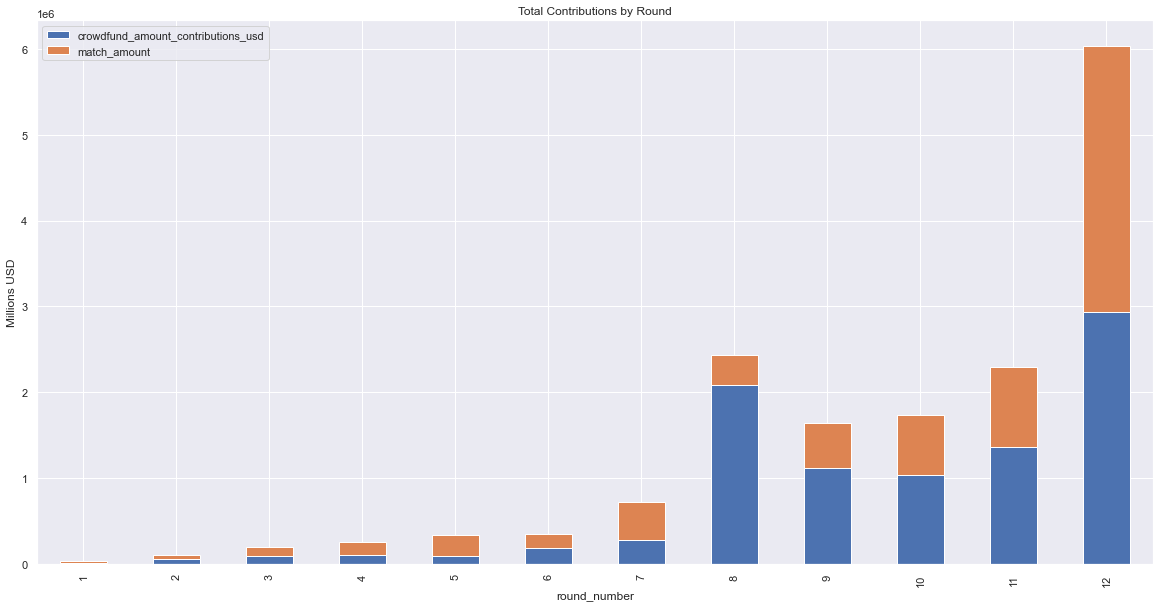

In [40]:
total_fund_amount_by_round = grants_data.groupby(["round_number"]).agg({"total": "sum"})
total_matched_by_round = grants_data.groupby(["round_number"]).agg({"match_amount": "sum"})
total_crowdfunded_by_round = grants_data.groupby(["round_number"]).agg({"crowdfund_amount_contributions_usd": "sum"})

summarized_totals = total_crowdfunded_by_round.merge(total_matched_by_round, on="round_number").reset_index()
display(summarized_totals.set_index("round_number").plot(kind="bar", stacked=True, title="Total Contributions by Round", figsize=(20,10), ylabel="Millions USD"))
display(summarized_totals)
summarized_totals = summarized_totals.merge(total_fund_amount_by_round, on="round_number")

Total funding amounts were on a fairly slow, linear growth until round 8 had an explosion of crowdfunding. This retracted a bit, then turned into a bit of an exponential curve. I'd suspect that matching amount likely has a strong correlation with how much individual contributors are willing to kick in, but that doesn't seem to be the case, at least not until round 12. We're going to dig into this later, but for now I wonder if the rising ETH-USD price made people more generous? Let's map the total funding amounts against the USD price of ETH (courtesy of [CoinDesk](https://www.coindesk.com/price/ethereum/)).

ETH-USD Price  USD Raised  ETH-USD %Change  USD Raised %Change
1      107.498873    38661.10              NaN                 NaN
2      133.751215   108544.41         0.244210            1.807587
3      190.877416   196995.11         0.427108            0.814880
4      144.374903   256173.09        -0.243625            0.300403
5      138.000000   334205.34        -0.044155            0.304608
6      236.000000   355166.61         0.710145            0.062720
7      384.275847   719101.55         0.628287            1.024688
8      636.340000  2431090.69         0.655946            2.380733
9     1878.910000  1637344.74         1.952683           -0.326498
10    2553.360000  1733505.44         0.358958            0.058730
11    3560.190000  2290025.89         0.394316            0.321038
12    4782.400000  6029524.56         0.343299            1.632950

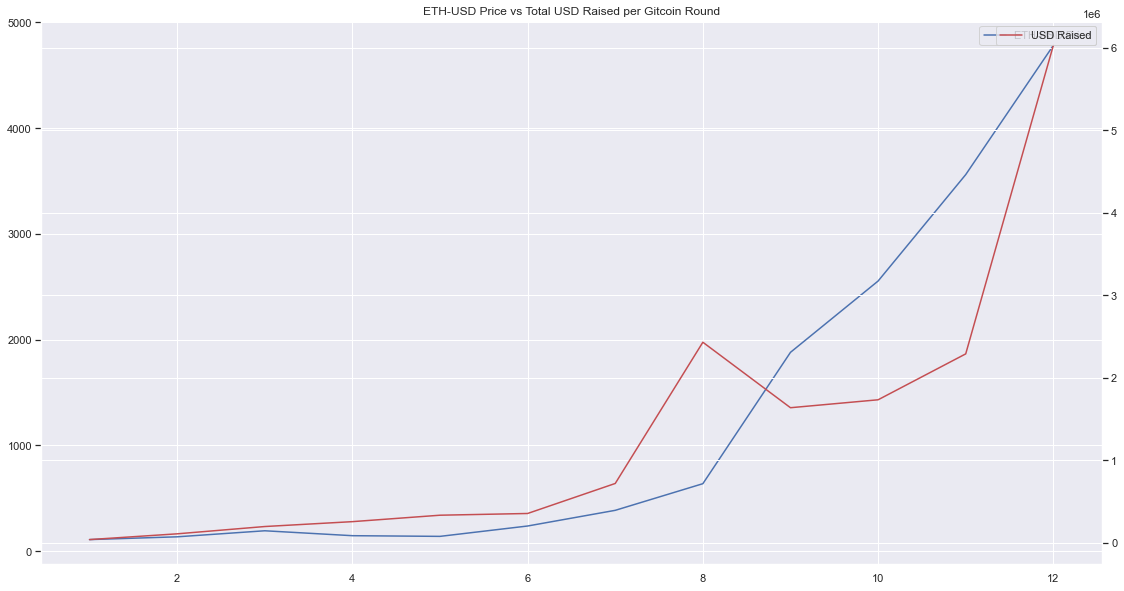

In [41]:
# Let's cut down the ETH price noise, and only grab the 24 hour high from the grant's opening date
eth_price = pd.read_csv("./data/eth-usd-coindesk.csv")
eth_price["Date"] = pd.to_datetime(eth_price["Date"],format='%Y-%m-%d')
opening_grants_dates = grants_data["round_start_date"].unique()
price_highs = eth_price.loc[eth_price["Date"].isin(opening_grants_dates)]["24h High (USD)"].reset_index().drop(columns=["index"])

# Cool, now merge it with our total funding amounts for Gitcoin rounds
price_highs.index = np.arange(1, len(price_highs)+1)
price_highs = price_highs.join(total_fund_amount_by_round)
price_highs = price_highs.rename(columns={"24h High (USD)": "ETH-USD Price", "total": "USD Raised"})

# Now build a plot
highest_price = price_highs.plot(y="ETH-USD Price")
total_funded = highest_price.twinx()
price_highs.plot(y="USD Raised", ax=total_funded, color="r", title="ETH-USD Price vs Total USD Raised per Gitcoin Round", figsize=(19,10))

# Calculate our percent changes from the last time
price_highs["ETH-USD %Change"] = price_highs["ETH-USD Price"].pct_change()
price_highs["USD Raised %Change"] = price_highs["USD Raised"].pct_change()
display(price_highs)

It seems that, while the ETH-USD price is maybe not **causing** the Gitcoin funding to increase at a similar rate, it certainly is **correlated**. This doesn't quite explain that dip in total funding after week 8. Perhaps that initial pop of sending ETH to $500+ drove excitement that later tapered off into "the new normal"? I imagine a lot of people got excited for some reason. I'm not sure WHY, but we can use Google trends to get some idea of how popular Gitcoin was at different periods of time.

![Gitcoin Google Trends](./data/google-trends.png)

Well that doesn't really match up. [Google trends](https://trends.google.com/trends/explore/TIMESERIES/1640127600?hl=en-US&tz=300&date=2019-02-01+2021-12-16&q=Gitcoin&sni=3) shows the `Gitcoin` term getting big in early June, 2021. That would be around the beginning of Round 10, which raised a total of $1,733,505.44. Google trends is probably an imperfect tool for something like this, but that huge spike is perplexing. Perhaps there was a major press push around then? I tried comparing the terms `Ethereum` and `Gitcoin` side-by-side, and `Gitcoin` barely registered. Either way, we'll have to dig more into the latest round, round 12, which shows a gigantic spike in all metrics. My bet is on the massive amount of matching money that was being offered.

### Feast or Famine?

A lot of projects are getting very little to no funding, with almost 20% total showing $0 raised, and plenty more showing very small sums of money. Let's look at how much of a disparity there is among these projects, and how things have changed over time. For this analysis, we'll consider any total raised under $10 to mean `little to no funding`. The world being as it is, $10 USD will go a lot further for you in India than it will in the U.S.A., but you'd have a hard time sustaining an individual (or a team for that matter) for much longer than a couple days anywhere for that amount. So we'll treat $10 as a cutoff. Other ranges are chosen a bit more arbitrarily.

Total Amount of Grants  Total Grants <= $10 Raised  \
Round Number                                                       
1                                 26                           2   
2                                 36                           2   
3                                 65                           1   
4                                152                           2   
5                                292                          53   
6                                607                         326   
7                                291                          35   
8                                371                          18   
9                                654                         163   
10                               723                          83   
11                               877                         203   
12                              1812                        1155   

              Total Grants $10 > Raised <= $1,000  \
Round Number                                        
1                                              10   
2                                              16   
3                                              33   
4                                              97   
5                                             177   
6                                             214   
7                                             158   
8                                             190   
9                                             327   
10                                            463   
11                                            478   
12                                            420   

              Total Grants $1,000 > Raised <= $10,000  \
Round Number                                            
1                                                  14   
2                                                  16   
3                                                  24   
4                                                  48   
5                                                  54   
6                                                  62   
7                                                  79   
8                                                 120   
9                                                 115   
10                                                126   
11                                                128   
12                                                140   

              Total Grants $10,000 > Raised  Percent of Grants <= $10 Raised  \
Round Number                                                                   
1                                         0                             0.08   
2                                         2                             0.06   
3                                         7                             0.02   
4                                         5                             0.01   
5                                         8                             0.18   
6                                         5                             0.54   
7                                        19                             0.12   
8                                        43                             0.05   
9                                        49                             0.25   
10                                       51                             0.11   
11                                       68                             0.23   
12                                       97                             0.64   

              Percent of Grants $10 > Raised <= $1,000  \
Round Number                                             
1                                                 0.38   
2                                                 0.44   
3                                                 0.51   
4                                                 0.64   
5                                                 

<AxesSubplot:title={'center':'Total Grants Funding Counts'}, xlabel='Round Number', ylabel='Total Grants'>

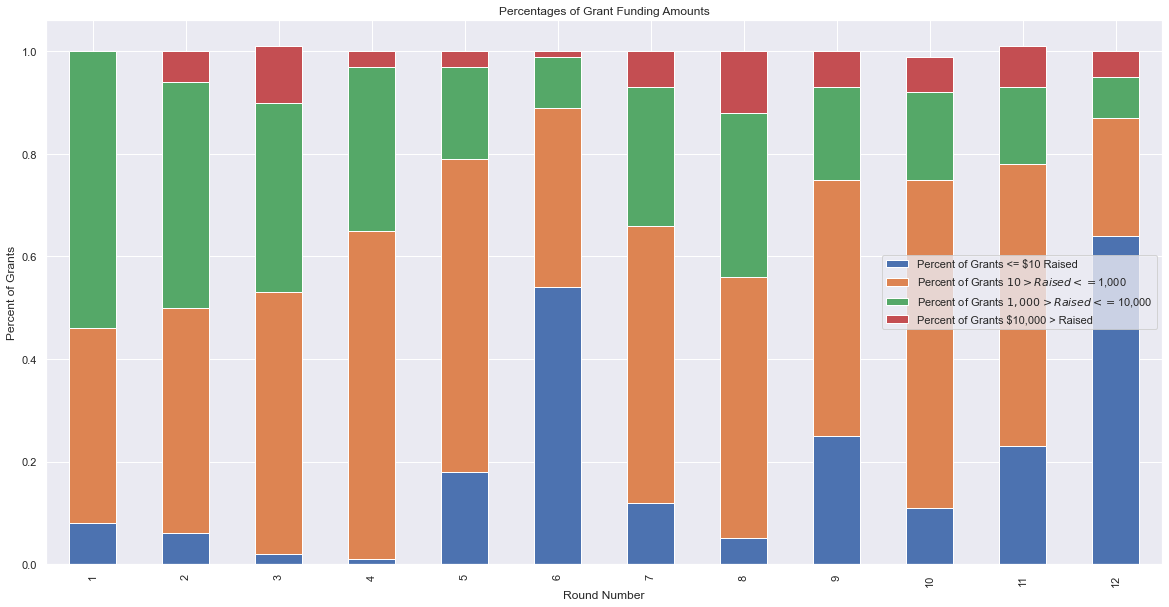

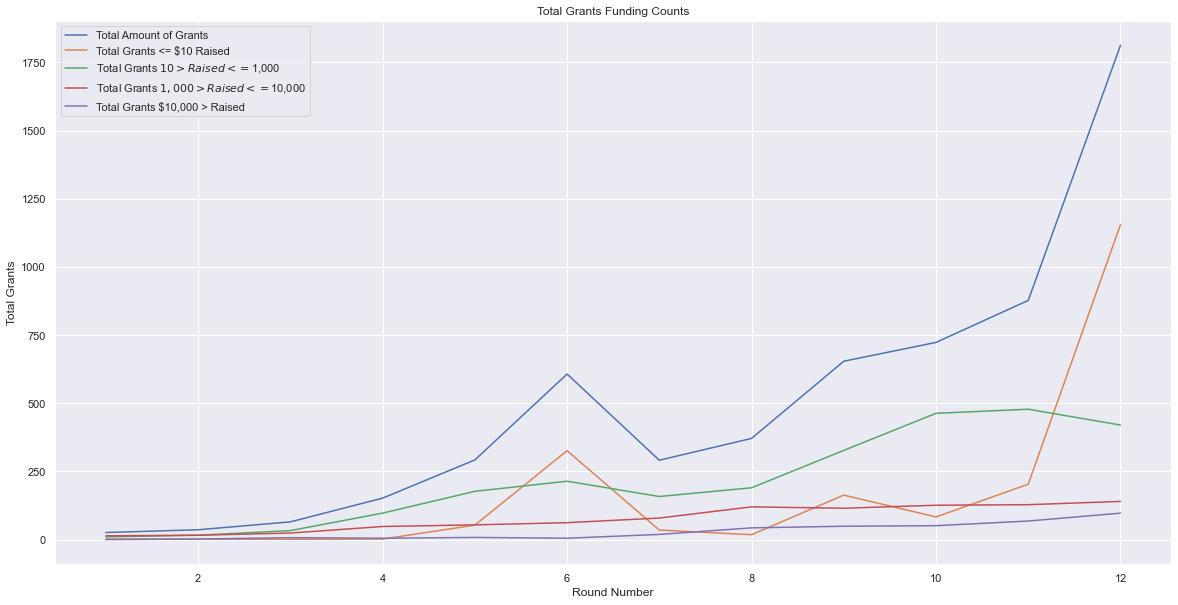

In [42]:
# I'm sure there's a cleaner, pandas native way of getting this done, but I'm wasting too much time looking for it.
# It's annoying because this feels like something that could be done in 1 or 2 clean lines. Advice is appreciated
results_dict = {
  "Round Number": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  "Total Amount of Grants": [],
  "Total Grants <= $10 Raised": [],
  "Total Grants $10 > Raised <= $1,000": [],
  "Total Grants $1,000 > Raised <= $10,000": [],
  "Total Grants $10,000 > Raised": [],
  "Percent of Grants <= $10 Raised": [],
  "Percent of Grants $10 > Raised <= $1,000": [],
  "Percent of Grants $1,000 > Raised <= $10,000": [],
  "Percent of Grants $10,000 > Raised": [],
}

# Loop through all our rounds and find out our total funded amounts
for i in range(1, 13):
  total_grants = (grants_data["round_number"] == i).sum()
  
  small_funded = grants_data.loc[(grants_data["total"] <= 10)&(grants_data["round_number"] == i), "total"].count()
  kinda_funded = grants_data.loc[(grants_data["total"] > 10)&(grants_data["total"] <= 1000)&(grants_data["round_number"] == i), "total"].count()
  mostly_funded = grants_data.loc[(grants_data["total"] > 1000)&(grants_data["total"] <= 10000)&(grants_data["round_number"] == i), "total"].count()
  large_funded = grants_data.loc[(grants_data["total"] > 10000)&(grants_data["round_number"] == i), "total"].count()

  results_dict["Total Amount of Grants"].append(total_grants)
  results_dict["Total Grants <= $10 Raised"].append(small_funded)
  results_dict["Total Grants $10 > Raised <= $1,000"].append(kinda_funded)
  results_dict["Total Grants $1,000 > Raised <= $10,000"].append(mostly_funded)
  results_dict["Total Grants $10,000 > Raised"].append(large_funded)

  results_dict["Percent of Grants <= $10 Raised"].append(round(small_funded / total_grants, 2))
  results_dict["Percent of Grants $10 > Raised <= $1,000"].append(round(kinda_funded / total_grants, 2))
  results_dict["Percent of Grants $1,000 > Raised <= $10,000"].append(round(mostly_funded / total_grants, 2))
  results_dict["Percent of Grants $10,000 > Raised"].append(round(large_funded / total_grants, 2))

funding_amounts_summary = pd.DataFrame(data=results_dict).set_index("Round Number")
display(funding_amounts_summary)
funding_amounts_percentages = funding_amounts_summary[funding_amounts_summary.columns.drop([
  "Total Amount of Grants", 
  "Total Grants <= $10 Raised", 
  "Total Grants $10 > Raised <= $1,000",
  "Total Grants $1,000 > Raised <= $10,000",
  "Total Grants $10,000 > Raised"])]
funding_amounts_totals = funding_amounts_summary[funding_amounts_summary.columns.drop([
  "Percent of Grants <= $10 Raised", 
  "Percent of Grants $10 > Raised <= $1,000", 
  "Percent of Grants $1,000 > Raised <= $10,000",
  "Percent of Grants $10,000 > Raised"])]
funding_amounts_percentages.plot(stacked=True, kind="bar", figsize=(20,10), ylabel="Percent of Grants", title="Percentages of Grant Funding Amounts")
funding_amounts_totals.plot(figsize=(20,10), ylabel="Total Grants", title="Total Grants Funding Counts")


Well that's interesting. It seems that the first Gitcoin rounds were fairly high in funding, with large portions of projects receiving more than $1,000 in funding. As the `Total Amount of Grants` experiences sharp increases, the funding distribution shifts dramatically with lots of projects receiving little funding. This seems like a simple conclusion that if there are more projects to choose from, a lot of them get lost in the mix and receive little funding (see rounds 6 and 12). As a user personally, I would be much more encouraged to donate money to a project that already has a decent amount of money allocated to it, meaning that my funds have a smaller chance of going to "waste". If I see a project has only raised $5 after a few days of funding, it's easy to imagine the project's creators being discouraged and abandoning the project, and donating an extra $10 to bring their total to $15 (ignoring matching) is unlikely to change that narrative.

I wanted to compare this trend to other charity grant systems, but couldn't find any that really emulate the approach that Gitcoin has. The best I could find is a [FiveThirtyEight analysis](https://fivethirtyeight.com/features/why-long-shot-candidates-are-raising-more-money-than-ever/) on long-shot Republican candidates fund raising for 2020 campaigns in the U.S. I think political candidate fundraising has *some* equivalencies to the Gitcoin system.

* It's open, so potential donators can see how much money has been raised, and also have rough odds as to how likely the candidate is to win
* Helping your preferred candidate win an election has some corollaries to funding an open-source project you consider interesting (pride, belief that it will help yourself and others)
* No one wants to waste money on a candidate that will lose anyway

The results of Republican candidate fund raising look pretty similar to the Gitcoin rounds: as more enter the race, fewer receive significant funding. It's obviously a flawed comparison (charity isn't winner-take-all like politics, politics tends to be more anger-driven, etc) but I think it shows that similar systems get similar results. 

In order to confirm this suspicion and dig deeper, I'd need more granular data on how grants are funded over time. I'd also like to see if there are any other similar charity models to compare against.

What about the projects that earned the most? And how does the amount of rounds you participate in correlate with the total funding you've received?

In [60]:
top_funded_grants = grants_data.groupby(["grant_id"]).agg({"total": "sum", "round_number": "count", "grant_title": "first"}).sort_values(["total"], ascending=False).rename(columns={"round_number": "Number of Rounds Present", "total": "Total USD Raised"})
display(top_funded_grants.head(30))
display(top_funded_grants.corr(method ='pearson'))

Total USD Raised  Number of Rounds Present  \
grant_id                                               
1668            1137038.22                         5   
2323             337821.69                         4   
149              323383.15                         9   
490              303809.72                         8   
2805             302569.78                         3   
3974             286988.88                         1   
1592             273472.88                         5   
4352             241184.20                         1   
24               227561.42                        12   
86               194468.26                         7   
25               186691.30                        12   
4083             184010.75                         1   
1632             176775.46                         5   
13               175487.78                        12   
821              170182.45                         7   
191              164383.45                         9   
143              164031.52                        10   
172              162448.84                         8   
4118             154552.02                         1   
3133             152102.95                         3   
1661             151348.33                         5   
1143             138751.38                         6   
238              130873.99                         6   
137              130083.60                        10   
40               127487.28                        12   
1093             120032.73                         4   
4119             115001.17                         1   
3857             112437.23                         1   
2679             111342.86                         3   
2594             107255.47                         3   

                                                grant_title  
grant_id                                                     
1668      Coin Center is educating policy makers about p...  
2323                                            Dark Forest  
149       Rotki - The portfolio tracker and accounting t...  
490                    POAP  (Proof of Attendance Protocol)  
2805                                        The Tor Project  
3974                         Electronic Frontier Foundation  
1592                                  Hardhat by Nomic Labs  
4352                                        ZigZag Exchange  
24                                  Prysm by Prysmatic Labs  
86                      Gitcoin Grants Core Team - Dev Fund  
25                          Lighthouse: Ethereum 2.0 Client  
4083                           Longevity Prize (by VitaDAO)  
1632            rekt.news - The dark web of DeFi journalism  
13                    ethers.js - Complete, Simple and Tiny  
821             Umbra:  Privacy Preserving Stealth Payments  
191       BrightID 🔆 Universal Proof of Uniqueness (Panv...  
143                              DAppNode  - Panvala League  
172       ZeroPool - Scaling anonymous transactions for ...  
4118                        The Blockchain Association (BA)  
3133      Li.Finance - Cross-Chain Bridge Aggregator + S...  
1661                                             EtherDrops  
1143          Frame: Privacy Focused Native Ethereum Wallet  
238                                                Bankless  
137                                                  Nimbus  
40                        EthHub - Ethereum Information Hub  
1093                                               Snapshot  
4119             Kick-starting the market for future carbon  
3857                                                 L2BEAT  
2679                         RSS3 - RSS with human curation  
2594      Fight for the Future is building and channelin...

Total USD Raised  Number of Rounds Present
Total USD Raised                  1.000000                  0.249447
Number of Rounds Present          0.249447                  1.000000

At first, I would say that the weak correlation between `Number of Rounds Present` and `Total USD Raised` would be surprising. But with how many new grants were started in Round 12, and the huge amount of funding Round 12 had shows that recent grants had a much better chance of getting big money.

## Overall Lessons Learned

* Gitcoin contributions are rising quickly
* The Price of ETH-USD combined with increased awareness is likely driving higher funding amounts

## Round 12 Specific Lessons

* The more grants there are, the more that get ignored. This seems partly due to the inevitability of attention-based systems (much easier to find something in a pile of 25 than a pile of 2,000) to favor the top. Also it's likely that participants are avoiding potential waste.
* With a big explosion of funds in Round 12, a large amount of new projects were able to get large amounts of funding

## Avenues Worthy of Further Exploration

* Find a good control to compare Gitcoin's quadratic funding approach against
* In a few years, check back on these projects that raised large amounts and see their progress vs. those that raised very little
* Obtain a deeper understanding and better cutoffs for funding amounts, rather than rather arbitrarily chosen values ($10, $1000, etc...)